# Pickle Load
Author: Jingcheng Shi
2025-06-02

In [2]:
import os
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

In [3]:
def merge_simulation_pickles(file_list):
    
    # 初始化整合后的数据结构
    data = {
        'Params': None,  # 默认使用第一个文件的参数
        'Results': {
            'listOfSingleSimulationDicts': []
        }
    }

    for file_path in file_list:
        with open(file_path, 'rb') as f:
            sing_data = pickle.load(f)

            # 记录参数（只保留第一个）
            if data['Params'] is None:
                data['Params'] = sing_data['Params']

            # 合并 simulation 结果
            data['Results']['listOfSingleSimulationDicts'].extend(
                sing_data['Results']['listOfSingleSimulationDicts']
            )

    print(f"Loaded {len(file_list)} files.")
    print(f"Total simulations merged: {len(data['Results']['listOfSingleSimulationDicts'])}")

    results = data['Results']
    simulation_list = results['listOfSingleSimulationDicts']

    print(f"Number of simulations: {len(simulation_list)}")
    print(len(simulation_list[0]['recordingTimeHighRes']))
    print(len(simulation_list[0]['recordingTimeLowRes']))

    return simulation_list

def plot_firing_rate_histograms(simulation_list, res_label='Low', ex_syn_num=10042+16070, inh_syn_num=1023+1637+150):
    firing_rates, ex_firing_rates, inh_firing_rates = [], [], []

    print('Number of simulations:', len(simulation_list))
    for simu_idx in range(len(simulation_list)):
        recording_time = simulation_list[simu_idx][f'recordingTime{res_label}Res']
        duration_seconds = recording_time[-1] / 1000.0  # ms -> s

        firing_rate = len(simulation_list[simu_idx]['outputSpikeTimes']) / duration_seconds
        
        ex_spikes = simulation_list[simu_idx]['exInputSpikeTimes']
        inh_spikes = simulation_list[simu_idx]['inhInputSpikeTimes']

        ex_rate = sum(len(spike_times) for spike_times in ex_spikes.values()) / (ex_syn_num * duration_seconds)
        inh_rate = sum(len(spike_times) for spike_times in inh_spikes.values()) / (inh_syn_num * duration_seconds) if inh_syn_num > 0 else 0
        
        firing_rates.append(firing_rate)
        ex_firing_rates.append(ex_rate)
        inh_firing_rates.append(inh_rate)

        if simu_idx == 0:
            print(f'Recording duration: {duration_seconds:.1f} seconds')
            print('number of ex segment:', len(ex_spikes))
            print('number of inh segment:', len(inh_spikes))

    avg_firing_rate = sum(firing_rates) / len(firing_rates)
    avg_ex_firing_rate = sum(ex_firing_rates) / len(ex_firing_rates)
    avg_inh_firing_rate = sum(inh_firing_rates) / len(inh_firing_rates)

    median_firing_rate = sorted(firing_rates)[len(firing_rates) // 2]
    median_ex_firing_rate = sorted(ex_firing_rates)[len(ex_firing_rates) // 2]
    median_inh_firing_rate = sorted(inh_firing_rates)[len(inh_firing_rates) // 2]

    plt.figure(figsize=(18, 4))
    for ax_idx in range(1, 4):
        plt.subplot(1, 3, ax_idx)
        plt.xlabel('Firing Rate (spikes per second)')
        plt.ylabel('Counts')
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        
        if ax_idx == 1:
            plt.hist(firing_rates, bins=30, color='blue', alpha=0.7)
            plt.title('Output Firing Rates')
            plt.axvline(median_firing_rate, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median_firing_rate:.2f}')
            plt.axvline(avg_firing_rate, color='black', linestyle='dashed', linewidth=1, label=f'Average: {avg_firing_rate:.2f}')
        elif ax_idx == 2:
            plt.hist(ex_firing_rates, bins=30, color='orange', alpha=0.7)
            plt.title('Excitatory Input Firing Rates')
            plt.axvline(median_ex_firing_rate, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median_ex_firing_rate:.2f}')
            plt.axvline(avg_ex_firing_rate, color='black', linestyle='dashed', linewidth=1, label=f'Average: {avg_ex_firing_rate:.2f}')
        elif ax_idx == 3:
            plt.hist(inh_firing_rates, bins=30, color='green', alpha=0.7)
            plt.title('Inhibitory Input Firing Rates')
            plt.axvline(median_inh_firing_rate, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median_inh_firing_rate:.2f}')
            plt.axvline(avg_inh_firing_rate, color='black', linestyle='dashed', linewidth=1, label=f'Average: {avg_inh_firing_rate:.2f}')
        plt.legend()

    plt.tight_layout()

def compute_firing_rate(spike_times, t_start, t_end, dt, sigma, num_syn):
    spike_train = np.zeros(int((t_end - t_start) / dt) + 1)
    for t in spike_times:
        if t_start <= t < t_end: #len(spike_train):
            spike_train[t-t_start] += 1
    firing_rate = gaussian_filter1d(spike_train, sigma=sigma) / ((dt / 1000) * num_syn) # spike_train / dt # gaussian_filter1d(spike_train, sigma=sigma) / dt  # Hz
    return firing_rate

def plot_simulation_detail(sim, t_start=0, t_end=5900, res_label='Low', ex_syn_num=10042+16070, inh_syn_num=1023+1637+150, sigma=20):
    time = sim[f'recordingTime{res_label}Res']
    mask = (time >= t_start) & (time <= t_end)
    time_sel = time[mask]
    soma_v = sim[f'somaVoltage{res_label}Res'][mask]
    # nexus_v = sim[f'nexusVoltage{res_label}Res'][mask]

    fig, axes = plt.subplots(4, 1, figsize=(min(40, 10*(t_end-t_start)/1000), 6*4.3/2.8), sharex=True, 
                            gridspec_kw={'height_ratios': [1, 0.3, 1.5, 1.5]})

    for ax_idx in range(len(axes)):
        axes[ax_idx].set_xlim(t_start, t_end)
        axes[ax_idx].spines['top'].set_visible(False)
        axes[ax_idx].spines['right'].set_visible(False)
        
    # ---------- Soma Voltage -----------
    axes[0].set_ylabel('Voltage (mV)')
    axes[0].set_ylim(-80, 0)  
    axes[0].plot(time_sel, soma_v, label='Soma Voltage', color='k')    
    axes[0].set_title(f'Soma Voltage Trace {res_label} Res')
    axes[0].legend(loc='upper left')

    # ----------- Output Spikes -----------
    output_spike_times = sim['outputSpikeTimes']
    output_spike_times = output_spike_times[(output_spike_times >= t_start) & (output_spike_times <= t_end)]
    axes[1].vlines(output_spike_times, 0, 1, color='purple', linewidth=1.0)
    axes[1].set_ylabel('Output')
    axes[1].set_yticks([1])
    axes[1].set_title('Output Spike Raster')

    # ----------- Exc/Inh Input Rasters -----------
    spikes_exc = sim['exInputSpikeTimes']
    spikes_inh = sim['inhInputSpikeTimes']
    for spikes, color, offset in [(spikes_exc, 'b', 0), (spikes_inh, 'r', len(spikes_exc))]:
        for syn_id, spike_times in spikes.items():
            spike_times_sel = [t for t in spike_times if t_start <= t <= t_end]
            axes[2].vlines(spike_times_sel, offset + syn_id - 0.4, offset + syn_id + 0.4, color=color, linewidth=2)
    axes[2].set_title('Excitatory and Inhibitory Input Raster')
    axes[2].set_ylabel('Input Syn ID')
    axes[2].set_xlabel('Time (ms)')

    # ----------- Firing rate plot ----------- 
    all_spike_times_exc = []
    for spike_times in spikes_exc.values():
        all_spike_times_exc.extend([t for t in spike_times if t_start <= t <= t_end])
    all_spike_times_inh = []
    for spike_times in spikes_inh.values():
        all_spike_times_inh.extend([t for t in spike_times if t_start <= t <= t_end])

    dt = 1 # ms
    time_bins = np.arange(t_start, t_end + dt, dt)
    firing_rate_exc = compute_firing_rate(all_spike_times_exc, t_start, t_end, dt, sigma=sigma, num_syn=ex_syn_num)
    firing_rate_inh = compute_firing_rate(all_spike_times_inh, t_start, t_end, dt, sigma=sigma, num_syn=inh_syn_num)

    axes[3].plot(time_bins, firing_rate_exc, color='b', label='Excitatory')
    axes[3].plot(time_bins, firing_rate_inh, color='r', label='Inhibitory')
    axes[3].set_ylabel('Firing rate (Hz)')
    axes[3].set_xlabel('Time (ms)')
    axes[3].set_title('Instantaneous Firing Rate (Gaussian smoothing, tau=20ms)')
    axes[3].legend()

    # print(output_spike_times)
    # print(f'Output firing rate: {len(output_spike_times) / (t_end - t_start) * 1000:.2f} Hz')
    print(f'Average Excitatory firing rate: {np.mean(firing_rate_exc):.2f} Hz')
    print(f'Average Inhibitory firing rate: {np.mean(firing_rate_inh):.2f} Hz')

    # ex_rate = sum(len(spike_times) for spike_times in spikes_exc.values())/ (ex_syn_num * (len(time)/1000))
    # inh_rate = sum(len(spike_times) for spike_times in spikes_inh.values()) / (inh_syn_num * (len(time)/1000))
    # print(f'Average Excitatory firing rate 2: {ex_rate:.2f} Hz')
    # print(f'Average Inhibitory firing rate 2: {inh_rate:.2f} Hz \n')

    plt.tight_layout()

### Orginal Data

Loaded 10 files.
Total simulations merged: 1280
recordingTimeHighRes
somaVoltageHighRes
nexusVoltageHighRes
recordingTimeLowRes
somaVoltageLowRes
nexusVoltageLowRes
exInputSpikeTimes
inhInputSpikeTimes
outputSpikeTimes
Number of simulations: 1280
48000
6000
Number of simulations: 1280
Recording duration: 6.0 seconds
number of ex segment: 639
number of inh segment: 639


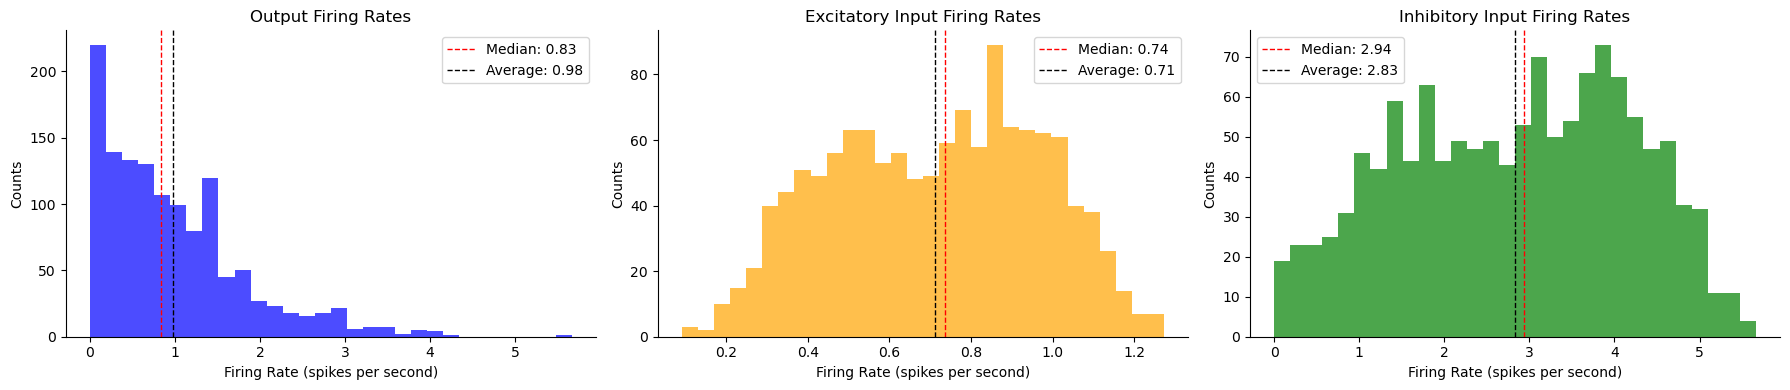

In [98]:
root_folder_path = './full_ergodic_train_batch_1/'
file_list = sorted(glob.glob(os.path.join(root_folder_path, 'L5PC*.p')))

simulation_list_ori = merge_simulation_pickles(file_list)
plot_firing_rate_histograms(simulation_list_ori, res_label='Low', ex_syn_num=8000, inh_syn_num=2000)

Average Excitatory firing rate: 0.48 Hz
Average Inhibitory firing rate: 1.90 Hz
Average Excitatory firing rate: 0.94 Hz
Average Inhibitory firing rate: 4.45 Hz
Average Excitatory firing rate: 0.82 Hz
Average Inhibitory firing rate: 3.77 Hz


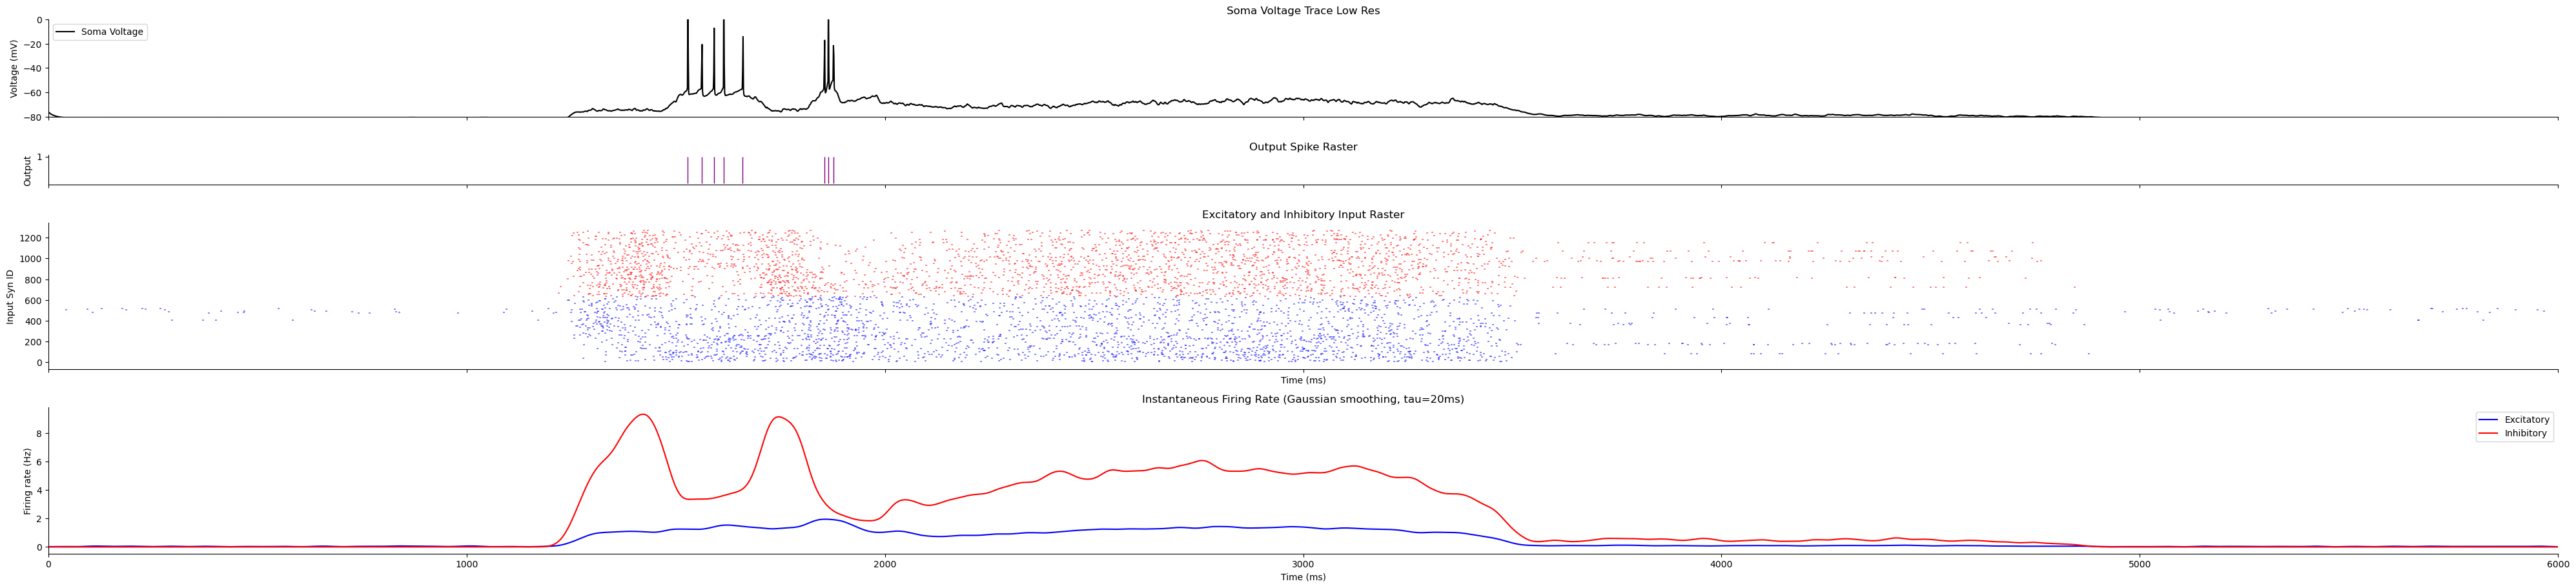

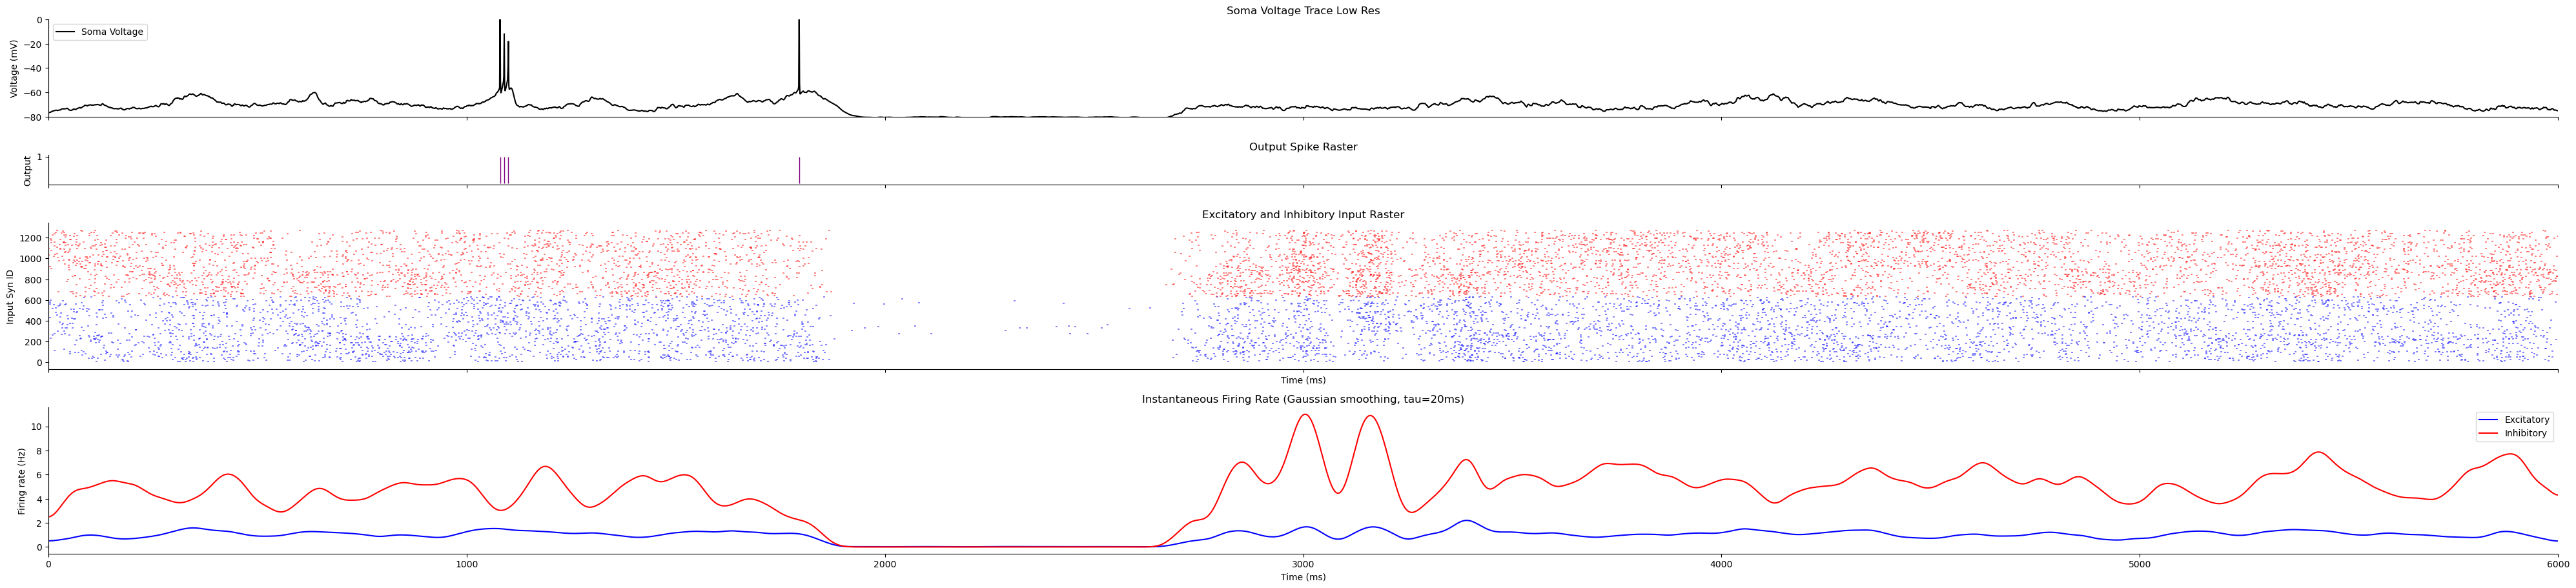

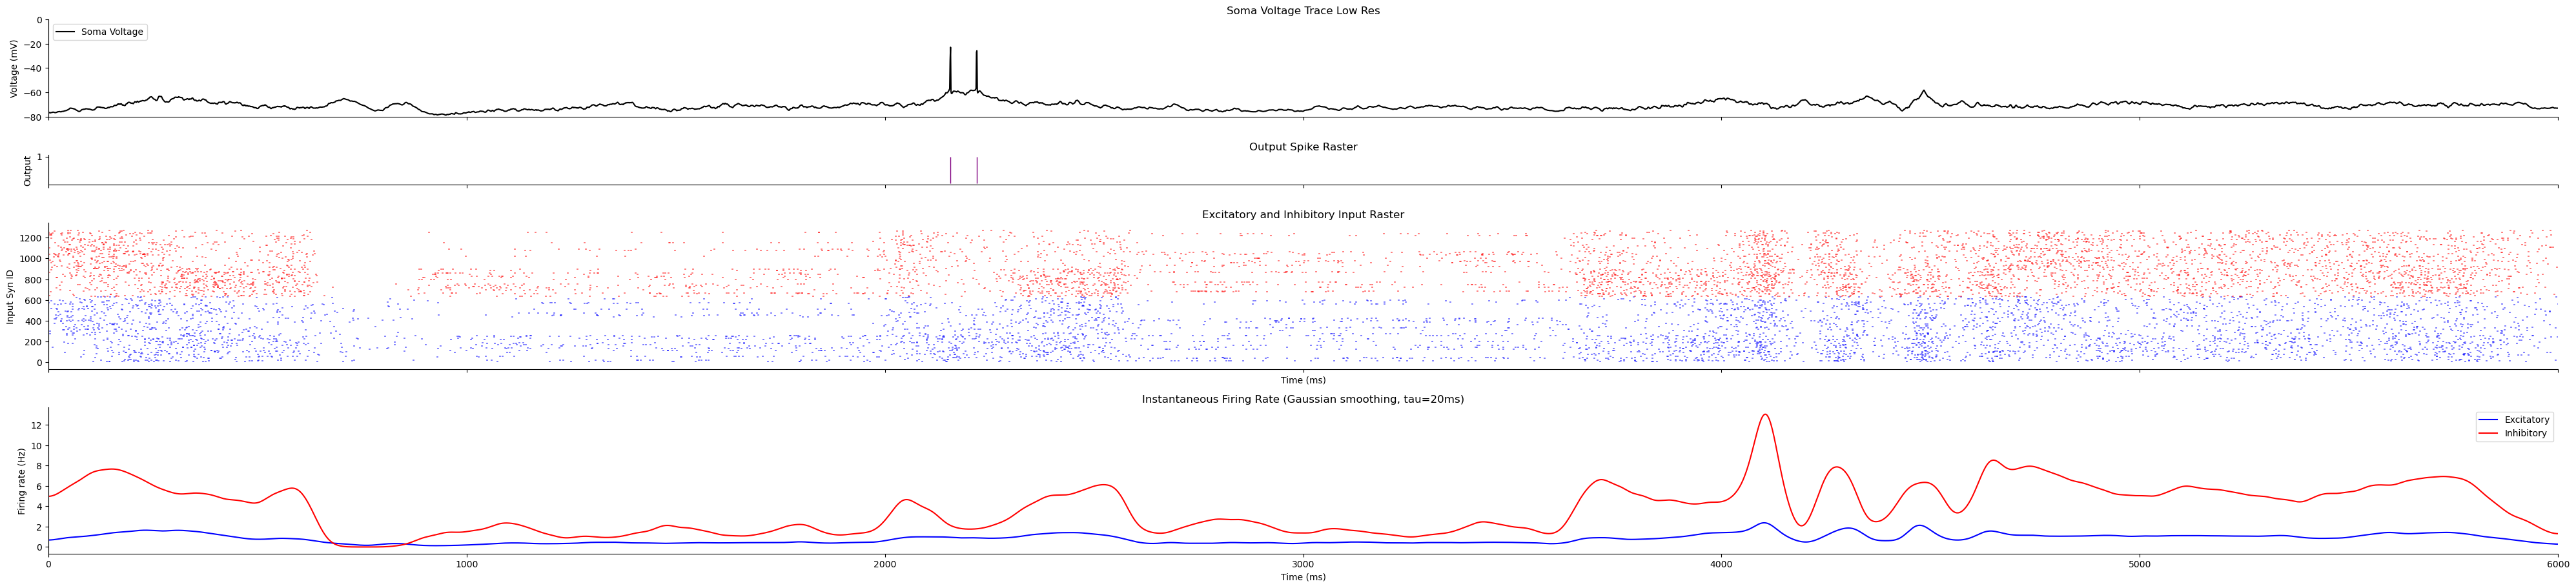

In [161]:
for epoch_idx in [1,2,3]:
    plot_simulation_detail(simulation_list_ori[epoch_idx-1], t_start=0, t_end=6000, res_label='Low', ex_syn_num=8000, inh_syn_num=2000)

### Aim 1

In [ ]:
root_folder_path = './full_output_dataset/'
simulation_list = merge_simulation_pickles(sorted(glob.glob(os.path.join(root_folder_path, 'L5PC*.p'))))
plot_firing_rate_histograms(simulation_list, res_label='Low')

Number of simulations: 400
Recording duration: 5.9 seconds
number of ex segment: 639
number of inh segment: 640


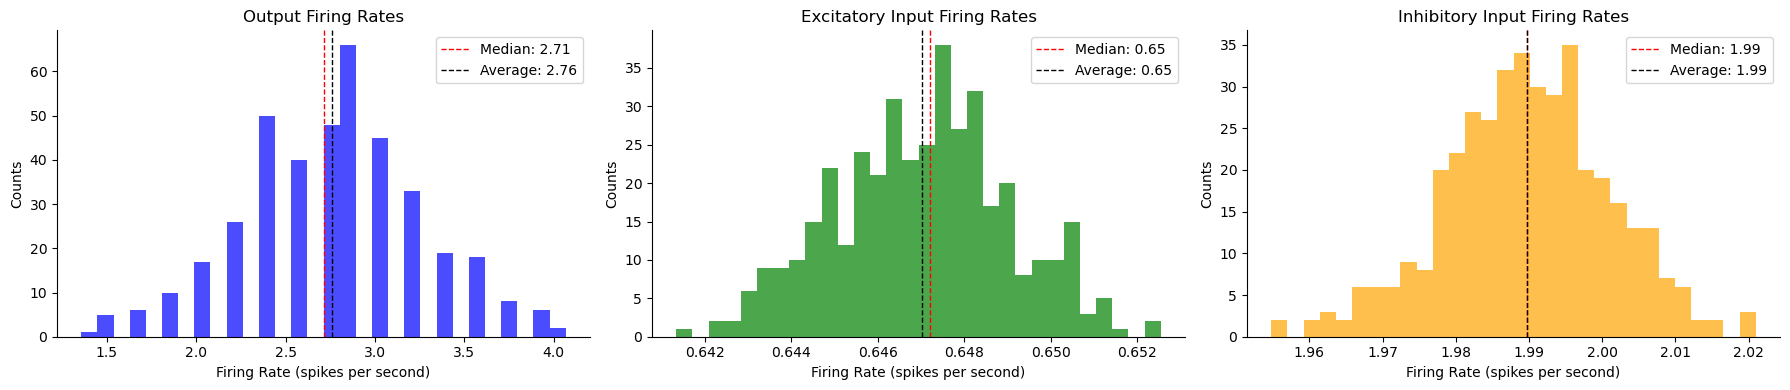

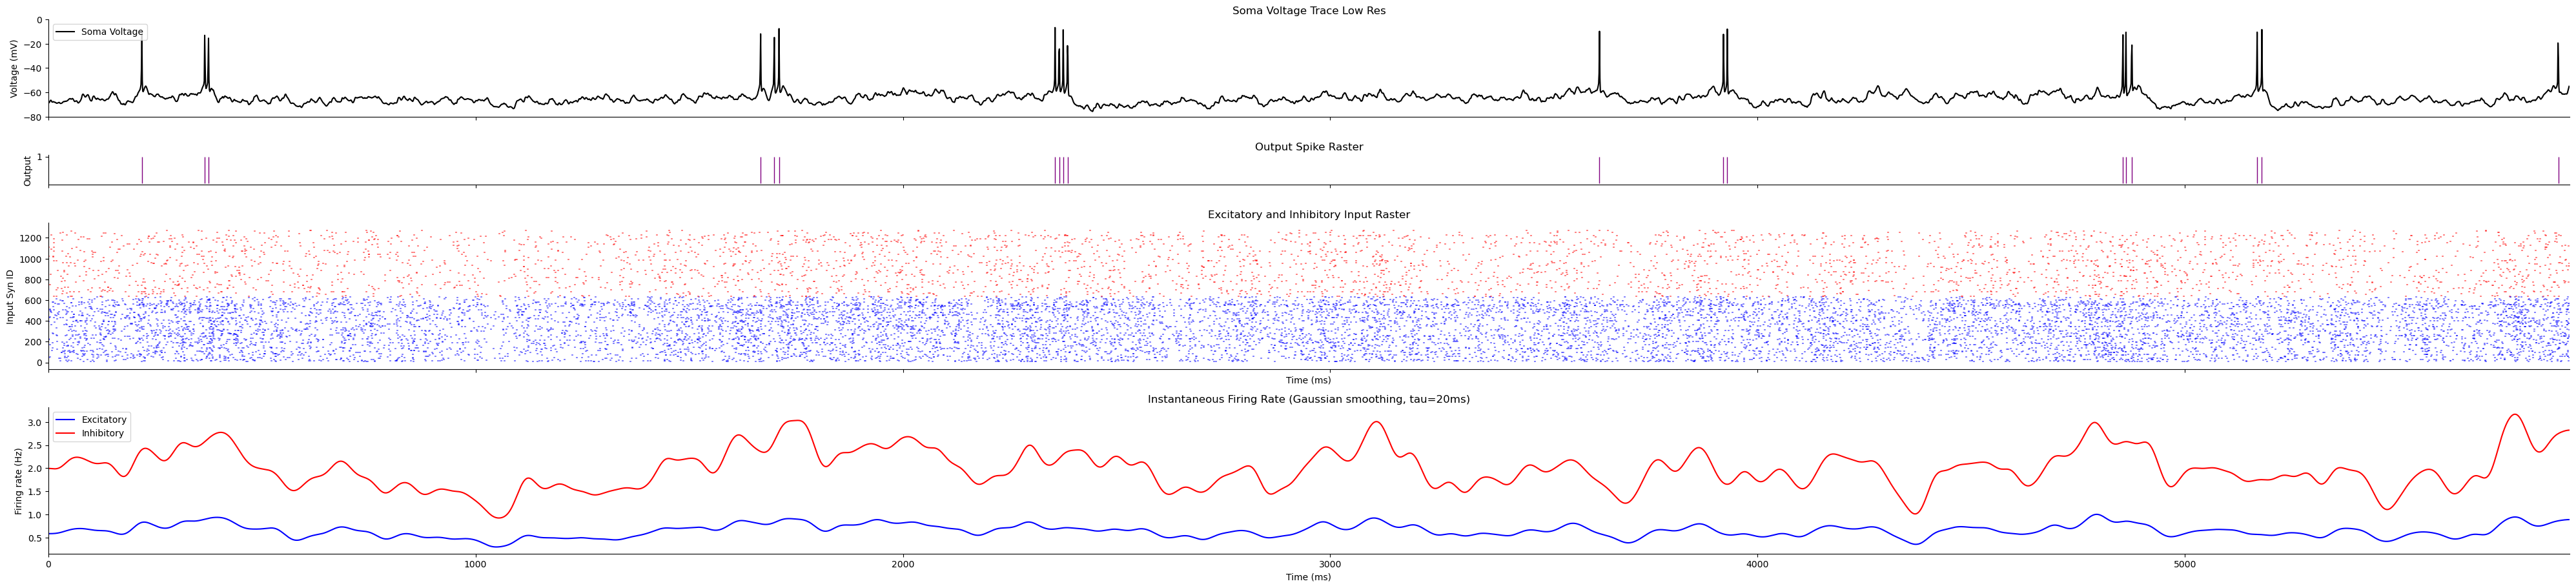

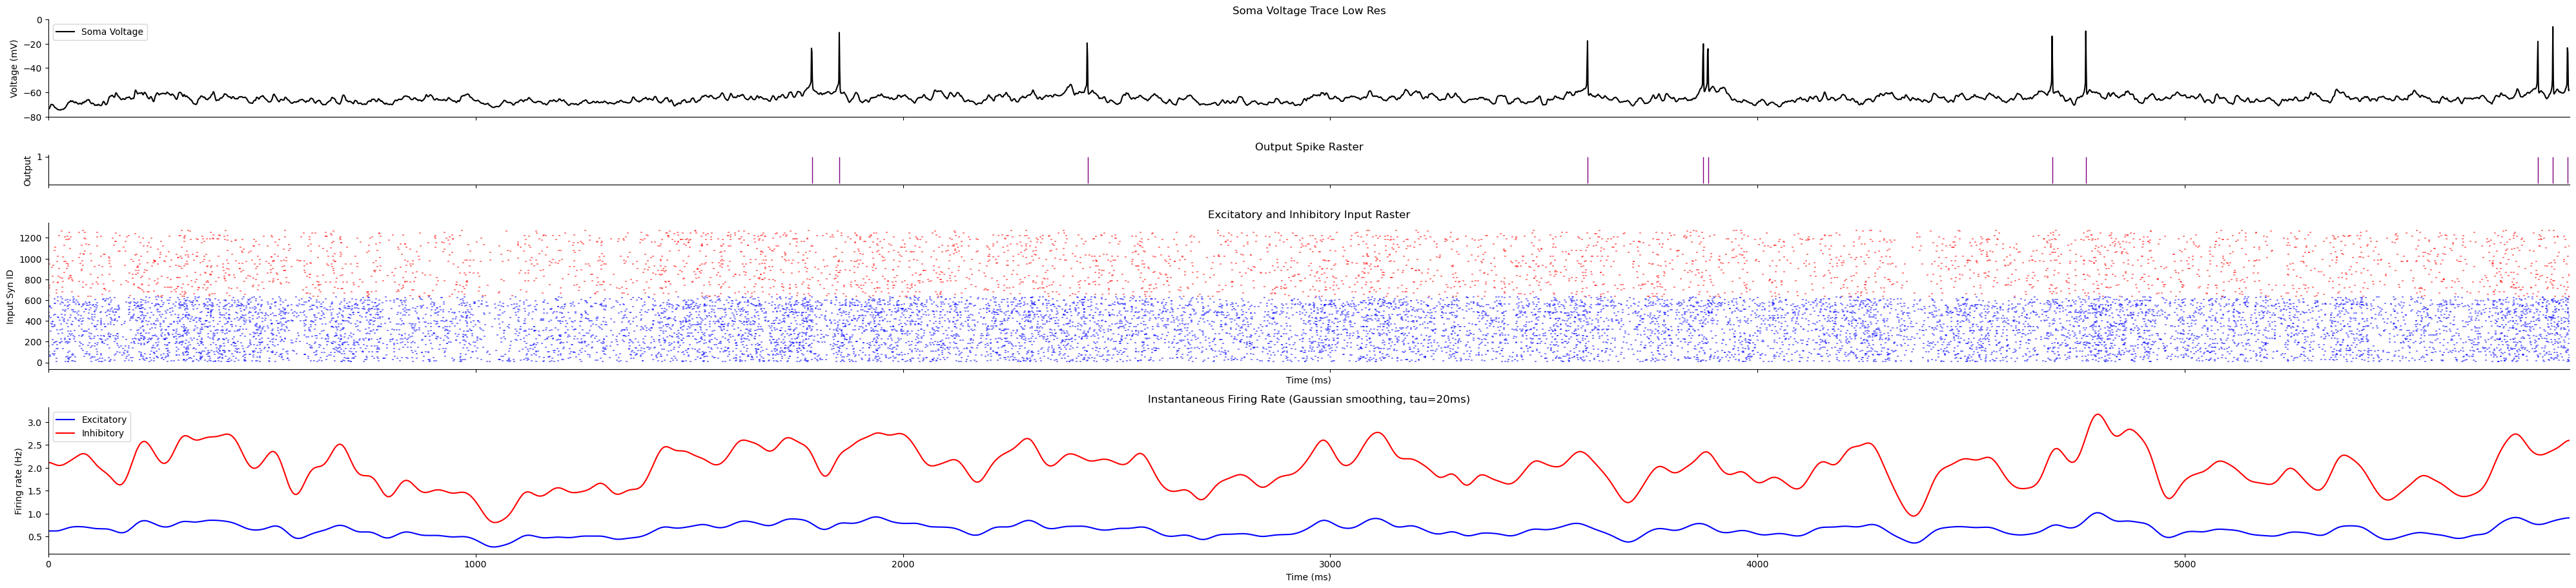

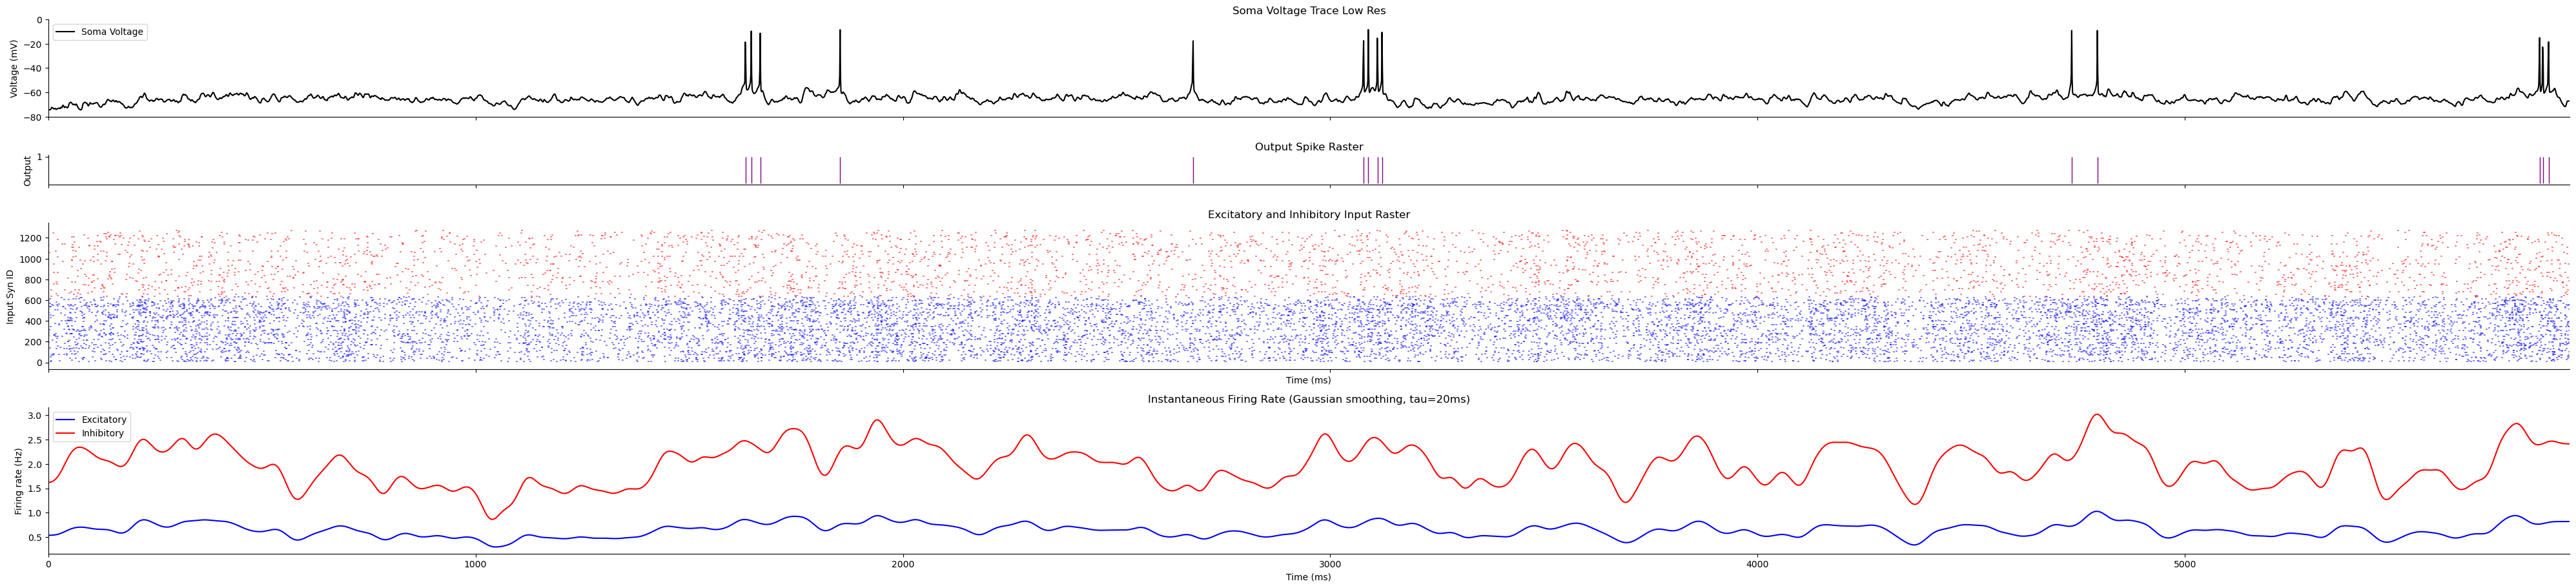

In [83]:
for epoch_idx in [1,2,3]:
    plot_simulation_detail(simulation_list[epoch_idx-1], t_start=0, t_end=5900, res_label='Low')

### Aim 1 Funcgroup 2

Loaded 10 files.
Total simulations merged: 900
Number of simulations: 900
236001
5900
Number of simulations: 900
Recording duration: 5.9 seconds
number of ex segment: 639
number of inh segment: 640


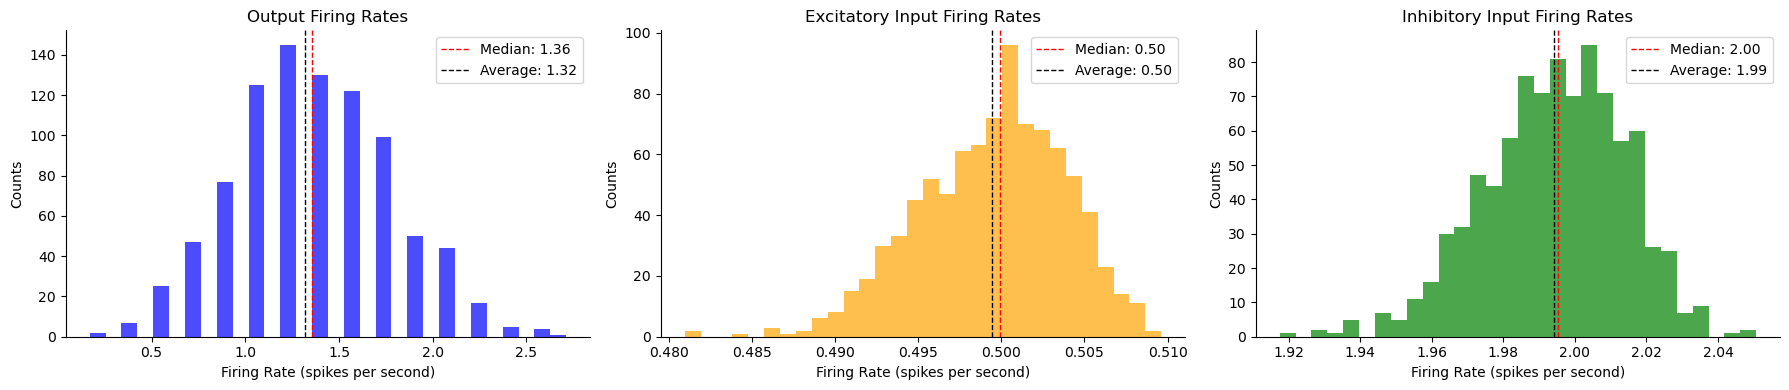

In [6]:
root_folder_path = './full_output_dataset_funcgroup2/'
simulation_list_funcgroup2 = merge_simulation_pickles(sorted(glob.glob(os.path.join(root_folder_path, 'L5PC*.p'))))
plot_firing_rate_histograms(simulation_list_funcgroup2, res_label='Low')

Loaded 10 files.
Total simulations merged: 1000
Number of simulations: 1000
240001
6000
Number of simulations: 1000
Recording duration: 6.0 seconds
number of ex segment: 639
number of inh segment: 640


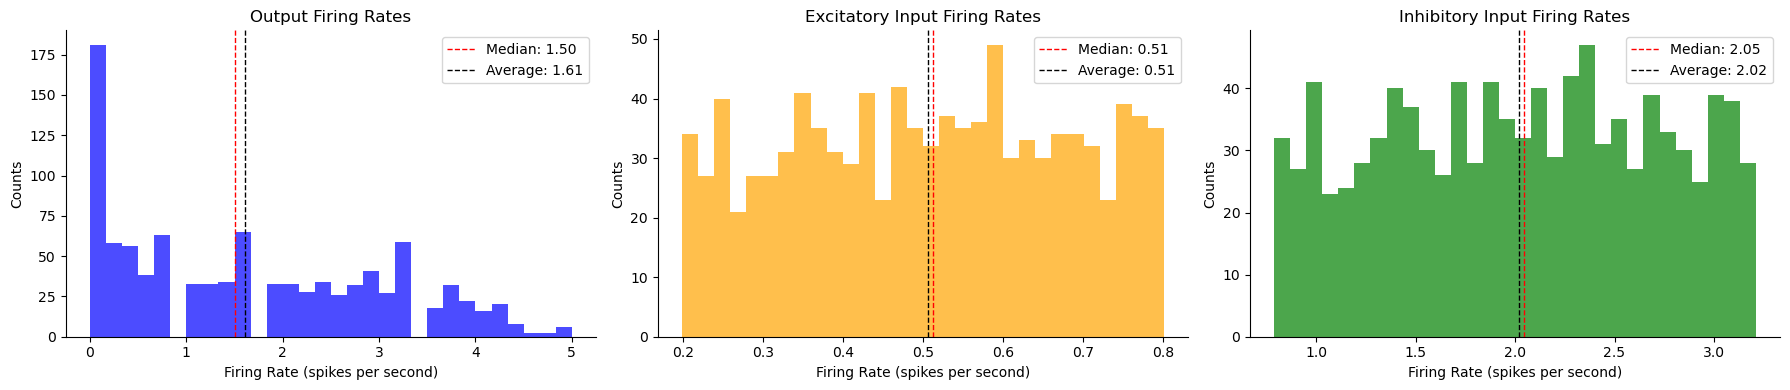

In [4]:
root_folder_path = './full_output_dataset_funcgroup2_var2/'
simulation_list_funcgroup2_var2 = merge_simulation_pickles(sorted(glob.glob(os.path.join(root_folder_path, 'L5PC*.p'))))
plot_firing_rate_histograms(simulation_list_funcgroup2_var2, res_label='Low')

[259]
[39]
[45]


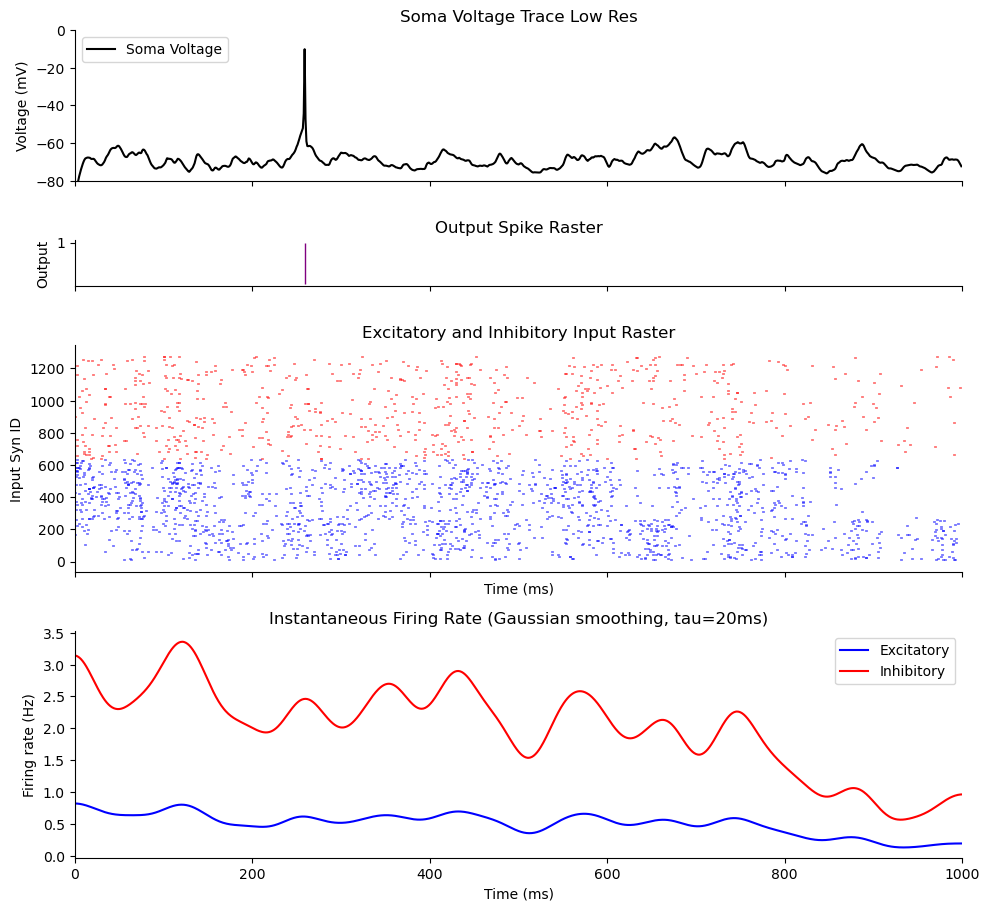

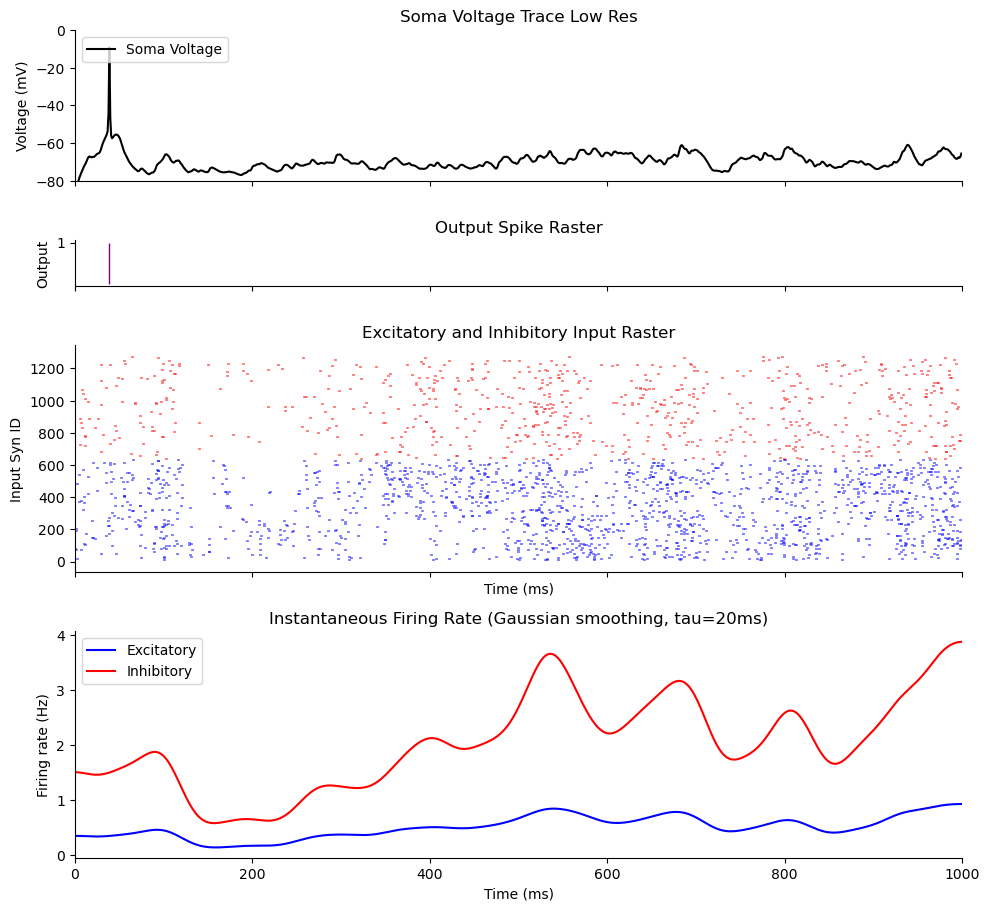

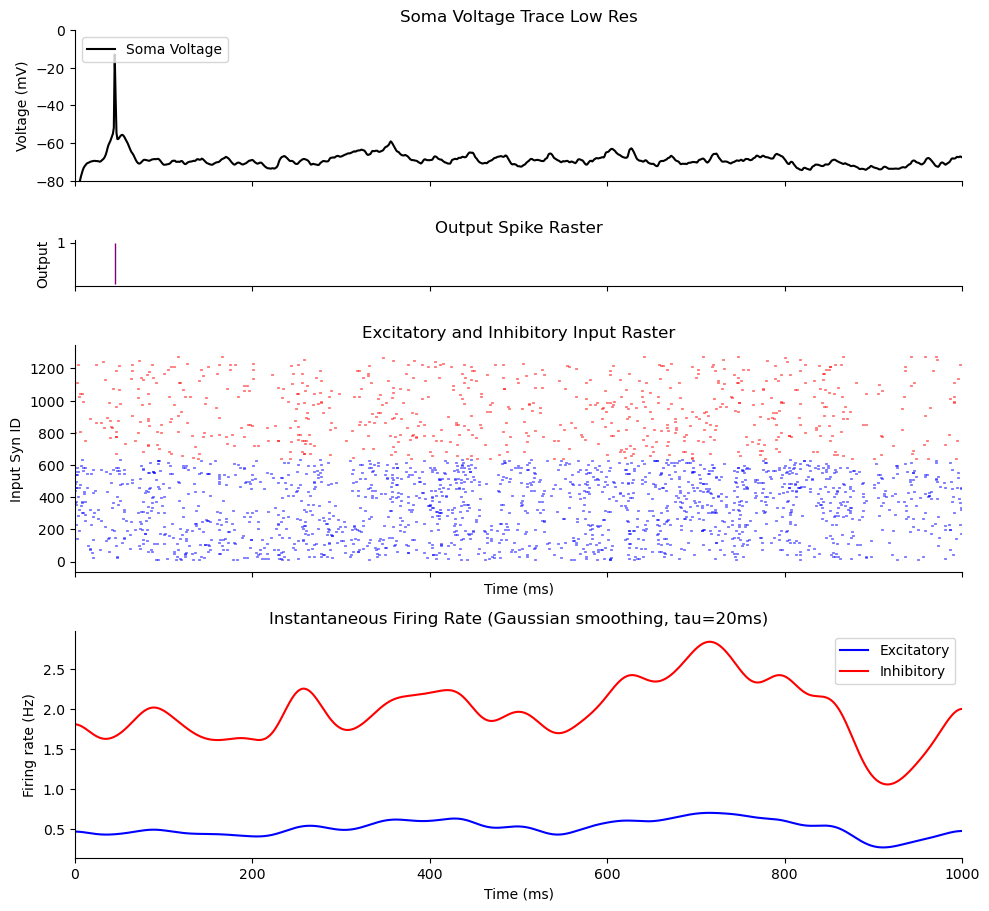

In [261]:
for epoch_idx in [1,5,6]:
    plot_simulation_detail(simulation_list_funcgroup2_var2[epoch_idx-1], t_start=0, t_end=1000, res_label='Low')

[259]
[]
[]


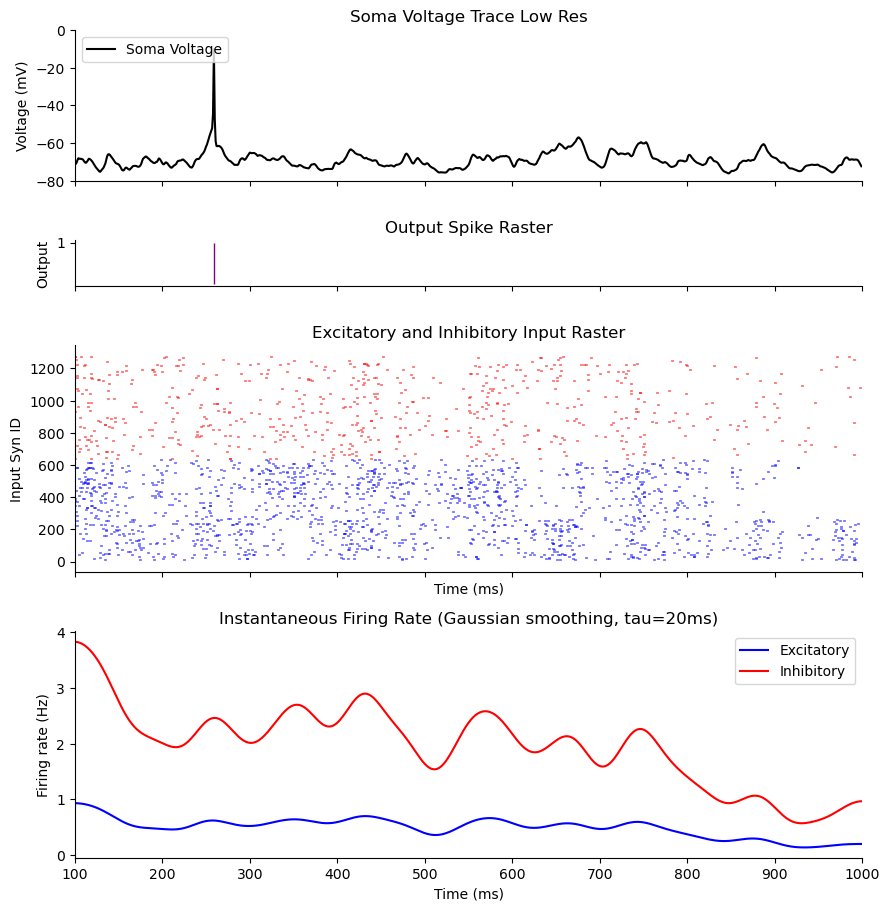

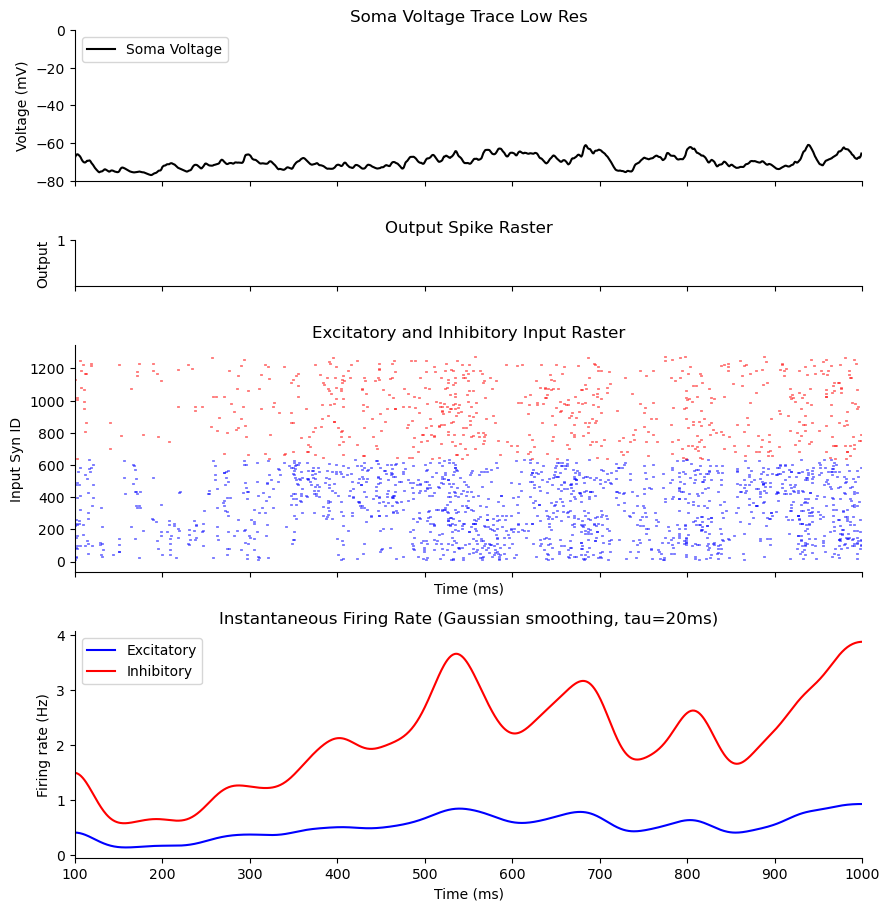

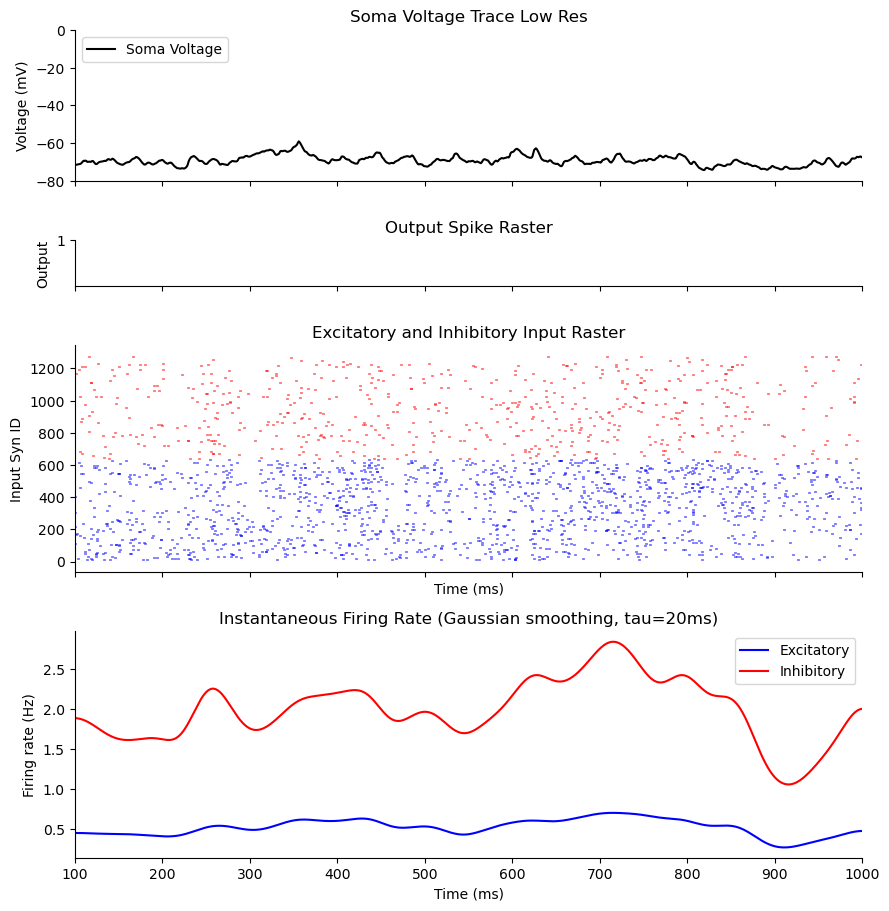

In [262]:
for epoch_idx in [1,5,6]:
    plot_simulation_detail(simulation_list_funcgroup2_var2[epoch_idx-1], t_start=100, t_end=1000, res_label='Low')

Average Excitatory firing rate: 0.35 Hz
Average Inhibitory firing rate: 1.40 Hz
Average Excitatory firing rate: 0.59 Hz
Average Inhibitory firing rate: 2.33 Hz
Average Excitatory firing rate: 0.54 Hz
Average Inhibitory firing rate: 2.14 Hz


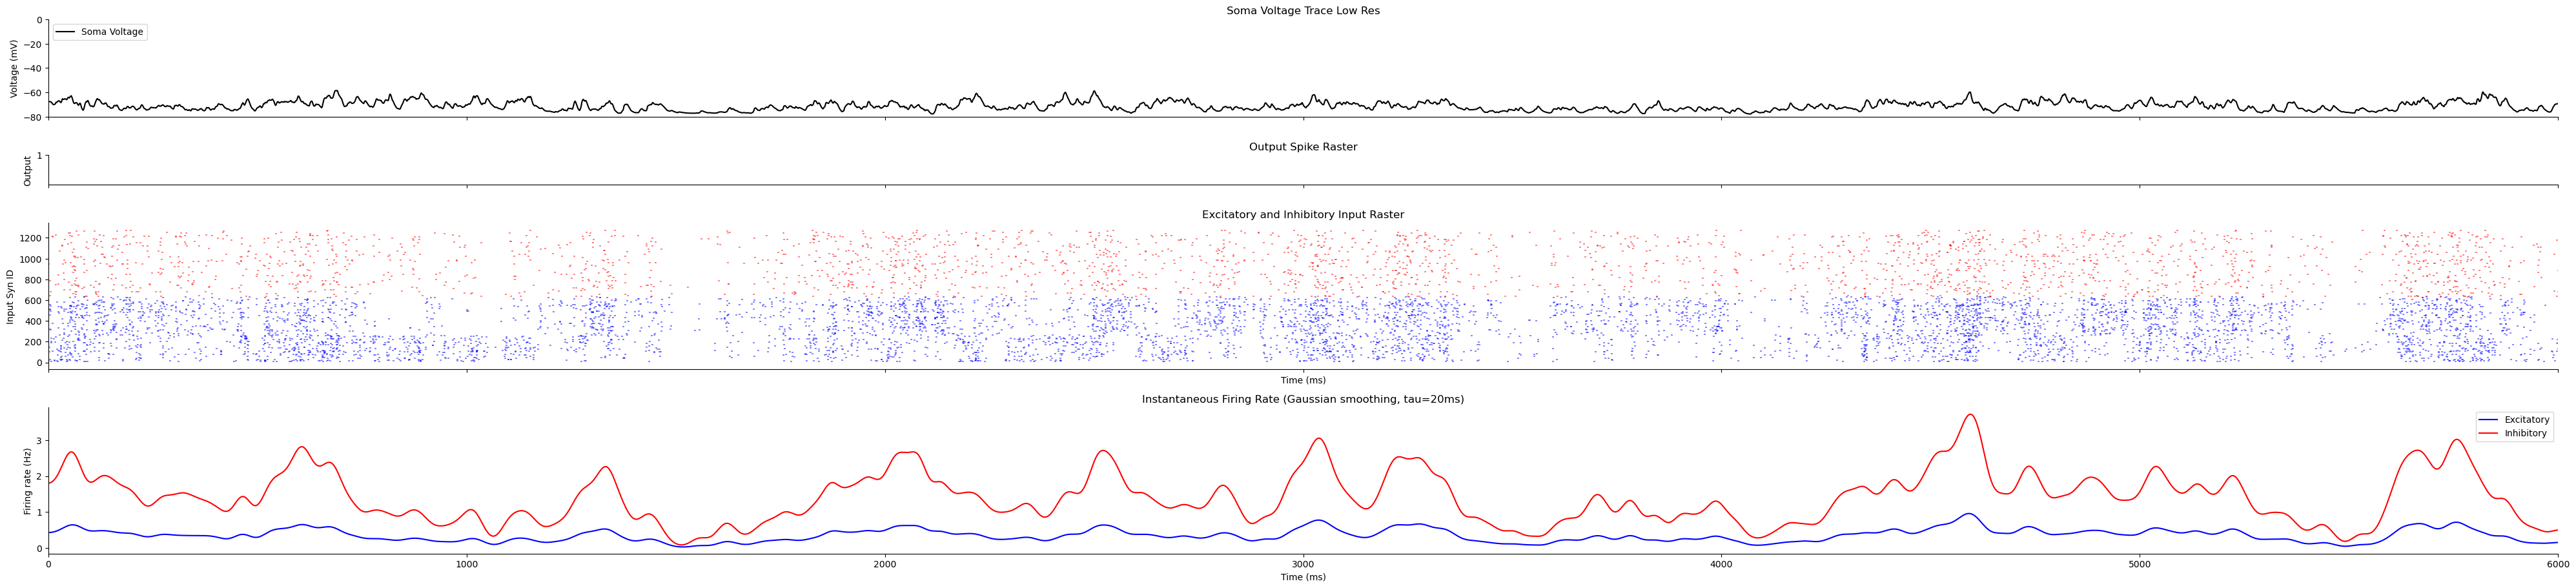

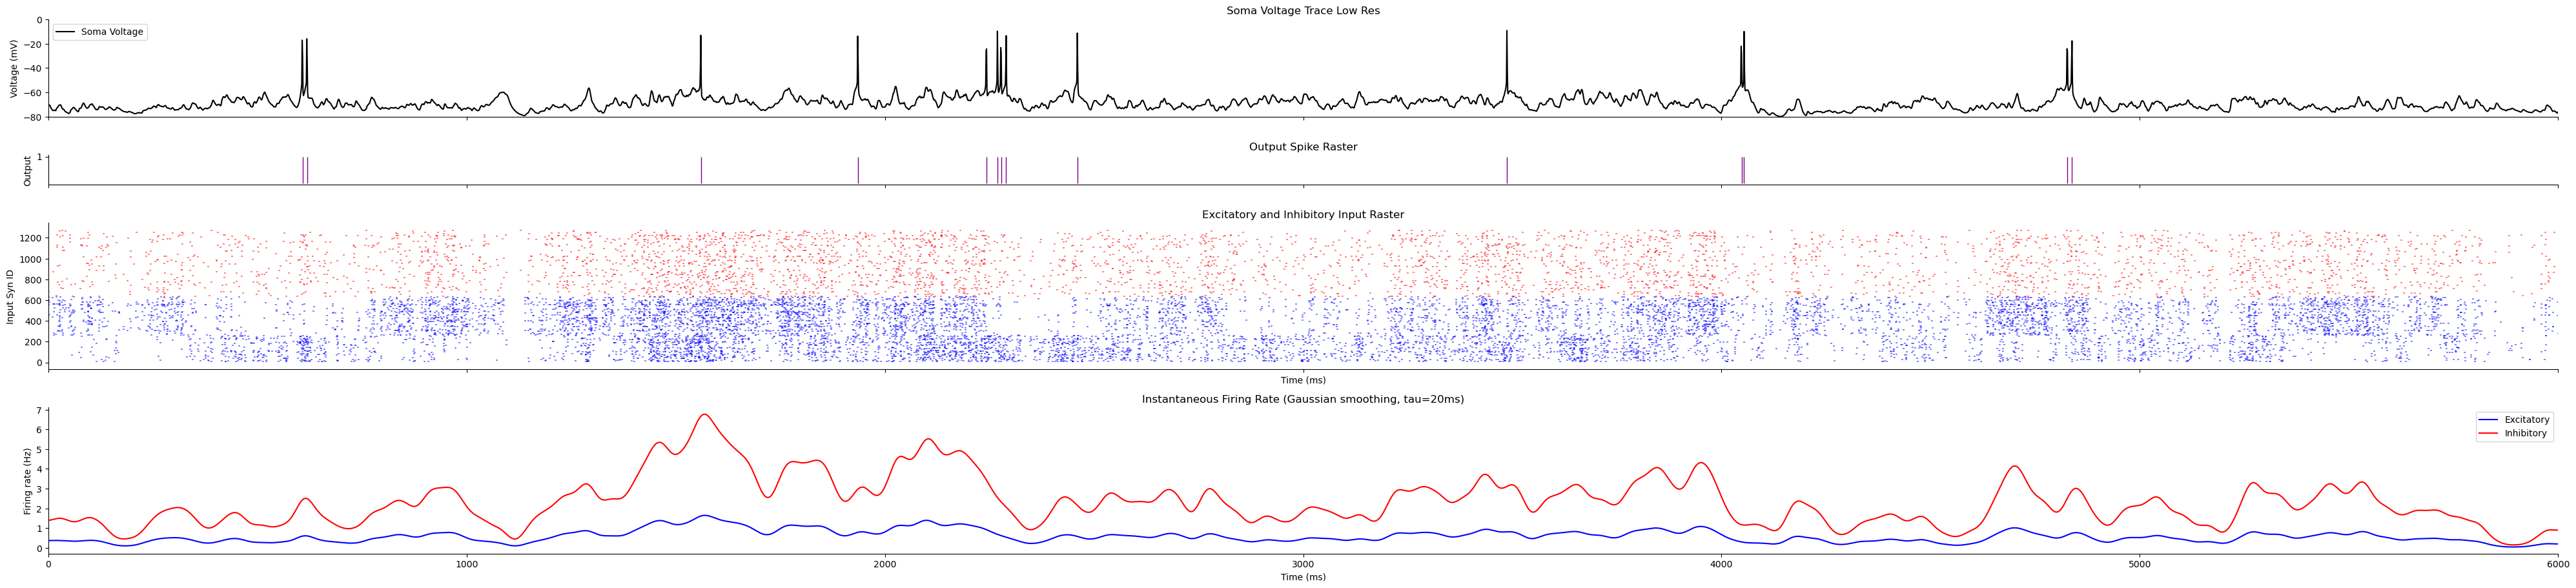

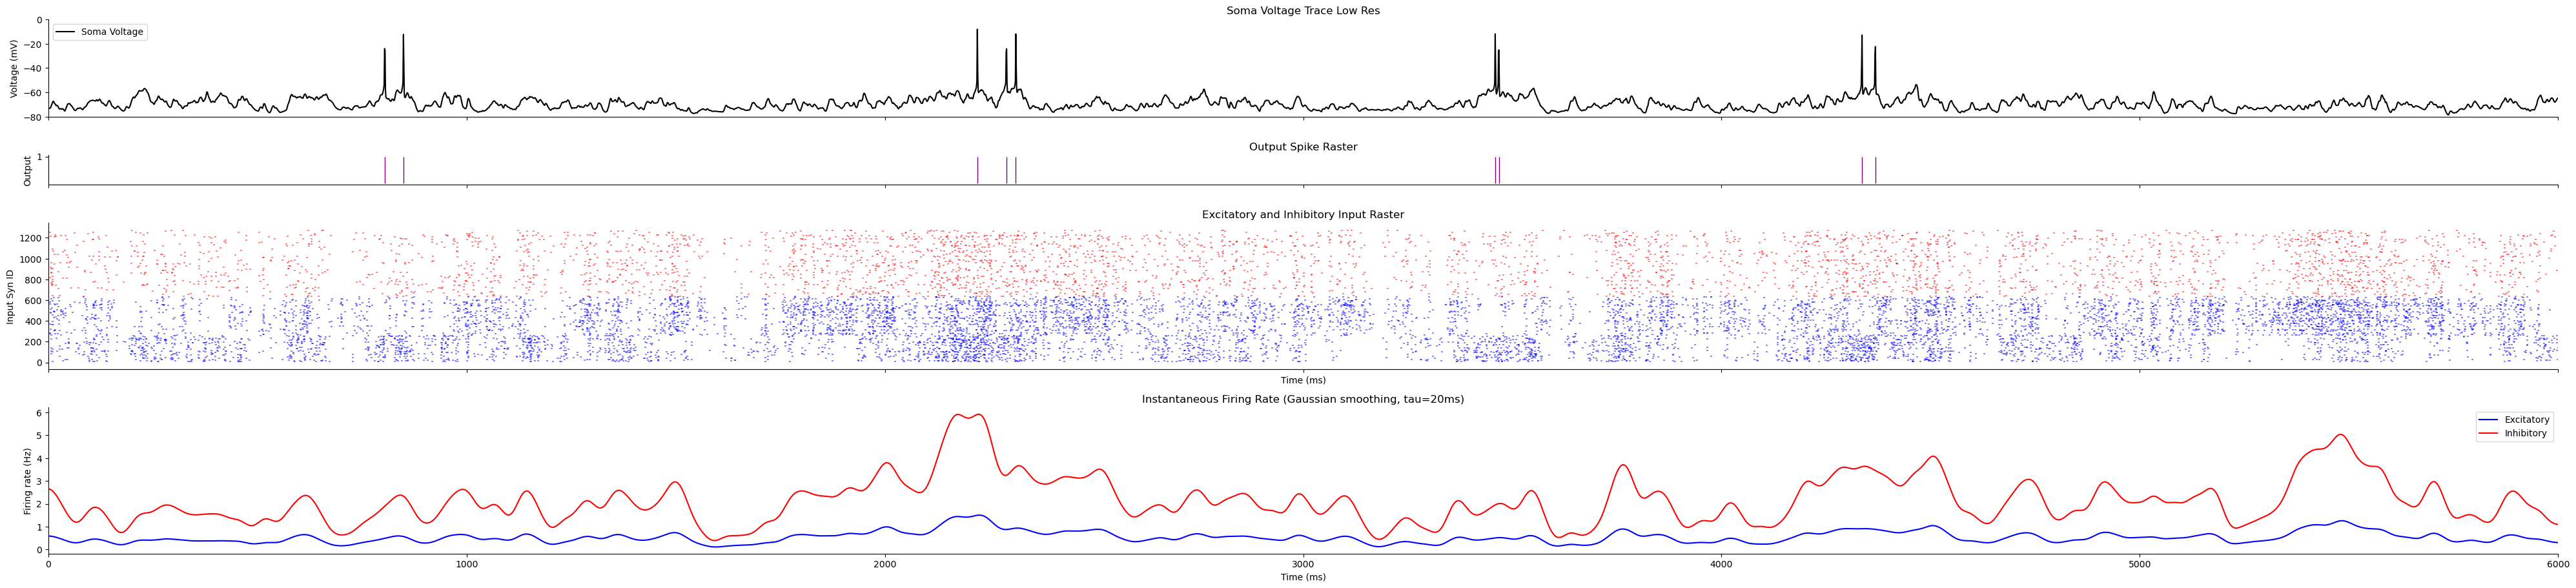

In [5]:
for epoch_idx in [1,105,306]:
    plot_simulation_detail(simulation_list_funcgroup2_var2[epoch_idx-1], t_start=0, t_end=6000, res_label='Low')

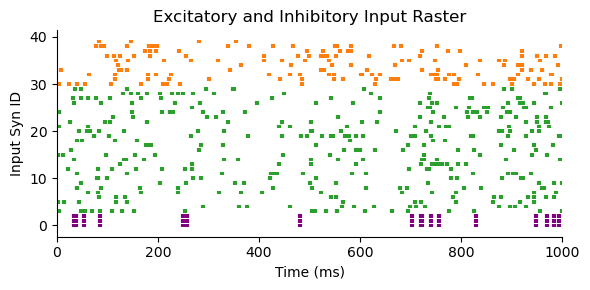

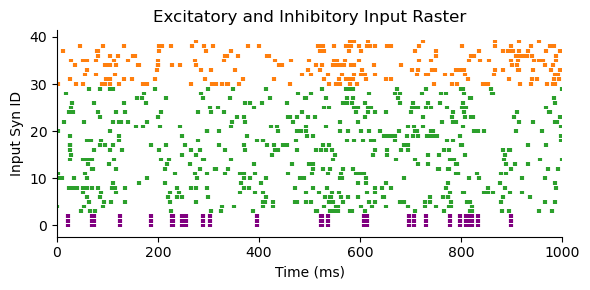

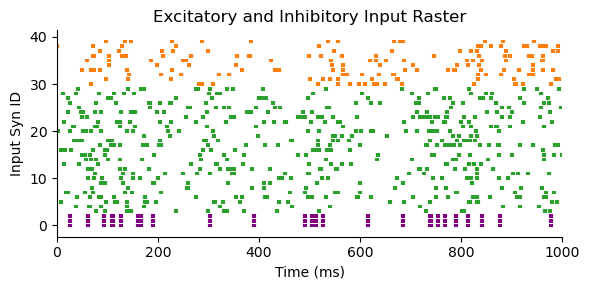

In [185]:
simu_idx = 122 # 123, 127
t_start, t_end = 0, 1000  # 要显示的时间范围（单位 ms）
res_label = 'Low'

for simu_idx in [122, 123, 127]:
    sim = simulation_list[simu_idx]

    time = sim[f'recordingTime{res_label}Res']
    # 获取对应时间范围的索引（布尔 mask）
    mask = (time >= t_start) & (time <= t_end)

    # 用 mask 提取对应时间段的数据
    time_sel = time[mask]
    soma_v = sim[f'somaVoltage{res_label}Res'][mask]
    nexus_v = sim[f'nexusVoltage{res_label}Res'][mask]

    fig, axes = plt.subplots(1, 1, figsize=(6, 3), sharex=True) 
                            #  gridspec_kw={'height_ratios': [1, 0.3, 2]})

    if not isinstance(axes, np.ndarray):
        axes = [axes]
        
    for ax_idx in range(len(axes)):
        axes[ax_idx].set_xlim(t_start, t_end)
        # Remove the top and right spines 
        axes[ax_idx].spines['top'].set_visible(False)
        axes[ax_idx].spines['right'].set_visible(False)
        
    # # ---------- Soma and Nexus Voltage Traces -----------
    # for ax_idx in range(1):
    #     axes[ax_idx].set_ylabel('Voltage (mV)')
    #     axes[ax_idx].set_ylim(-90, 20)  

    #     if ax_idx == 0:
    #         axes[ax_idx].plot(time_sel, soma_v, label='Soma Voltage', color='tab:blue')    
    #         axes[ax_idx].set_title(f'Soma Voltage Trace {res_label} Res')
    #     # else:
    #     #     axes[ax_idx].plot(time_sel, nexus_v, label='Nexus Voltage', color='tab:orange')
    #     #     axes[ax_idx].set_title(f'Nexus Voltage Trace {res_label} Res')

    #     # axes[ax_idx].legend(loc='upper left')

    # # ----------- Output Spikes -----------
    # output_spike_times = sim['outputSpikeTimes']
    # output_spike_times = output_spike_times[(output_spike_times >= t_start) & (output_spike_times <= t_end)]
    # axes[1].vlines(output_spike_times, 0, 1, color='purple', linewidth=1.0)
    # axes[1].set_ylabel('Output')
    # axes[1].set_yticks([1])
    # axes[1].set_title('Output Spike Raster')

    # ----------- Excitatory and Inhibitory Input Rasters -----------
    spikes_exc = sim['exInputSpikeTimes']
    spikes_inh = sim['inhInputSpikeTimes']
    highlight_exc_ids = [0, 1, 2]  # 要高亮的 excitatory synapse ID
    for spikes, base_color, read_length, offset in [(spikes_exc, 'C2', 30, 0), (spikes_inh, 'C1', 10, 30)]: # C0: blue, C3: red
        for syn_id, spike_times in list(spikes.items())[:read_length]:  # 只读取前 read_length 个 synapse
            spike_times_sel = [t for t in spike_times if t_start <= t <= t_end] 
            # color = 'C1' if base_color == 'C0' and syn_id in highlight_exc_ids else base_color
            if base_color == 'C2' and syn_id in highlight_exc_ids:
                color = 'purple'
                # spikes_exc_fixed = simulation_list[123]['exInputSpikeTimes']  # 选择一个特定的 simulation 来获取 spike_times
                spike_times = list(spikes_exc.items())[0][1] #[1][1]: yspike=0; [2][1]: yspike=1 (simu_idx=126)
                spike_times_sel = [t for t in spike_times if t_start <= t <= t_end]
            else:
                color = base_color
            axes[0].vlines(spike_times_sel, offset + syn_id - 0.4, offset + syn_id + 0.4, color=color, linewidth=3)

    axes[0].set_title('Excitatory and Inhibitory Input Raster')
    axes[0].set_ylabel('Input Syn ID')
    axes[0].set_xlabel('Time (ms)')

    plt.tight_layout()
    plt.savefig(f'simulation_{simu_idx}_raster.png', dpi=300)